In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
pd.options.display.float_format = '{:.0f}'.format
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
plt.style.use('seaborn-white')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5



import xgboost as xgb
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 30)
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
pd.options.display.max_columns =100
import pyodbc
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns ; sns.set(style='white')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest,  f_regression, f_classif, chi2
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix , roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.utils import resample
import random
from sklearn import decomposition

In [434]:
df = pd.read_csv('train_csv.csv', sep='\t')
df2 = pd.read_csv('features_train_csv.csv', sep='\t')

df['buy_time'] = pd.to_datetime(df['buy_time'].apply(lambda x: datetime.fromtimestamp(x))) # переводим unix в формат времени
df2['buy_time'] = pd.to_datetime(df2['buy_time'].apply(lambda x: datetime.fromtimestamp(x))) # переводим unix в формат времени
df['month'] = df['buy_time'].dt.month

In [31]:
df.head()

,id,vas_id,buy_time,target
0,721013,4,2018-11-19,1
1,1123097,6,2018-08-13,1
2,1123712,1,2018-08-06,0
3,132,2,2018-07-23,0
4,1055072,5,2018-10-15,0


In [32]:
df2.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,465518,721013,2018-11-19,-97,109,-111,87,-116,65,-16,...,-631,-609,-26,-38,-196,-21,-1,-12,-0,1
1,4244798,1123097,2018-08-13,-97,-196,-111,-249,-116,-270,-16,...,-977,-614,-26,-38,-299,-26,-1,-12,-0,0
2,2711621,1123712,2018-08-06,-88,-376,-93,-393,-99,-414,-8,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
3,2628022,132,2018-07-23,-97,217,-111,173,-116,152,-16,...,-603,-273,-25,-38,9,-23,-1,-10,1,1
4,387766,1055072,2018-10-15,-35,57,-48,97,-54,76,31,...,24783,8305,-24,-34,658,62,-1,16,-0,0


In [358]:
feature, unique_values = [], []
for i in df2.iloc[:, 3:].columns:
    feature.append(i)
    unique_values.append(df2[i].nunique())
unique_features = pd.DataFrame([feature, unique_values]).T
unique_features.columns = 'feature', 'quant'
unique_features.sort_values(by='quant', inplace=True)

print('num categorial features =', unique_features[ (unique_features['quant']<=10) & (unique_features['quant']>2) 
                                                  ]['feature'].count())
print('num single value features =', unique_features[unique_features['quant']==1]['feature'].count())
print('num bin features =', unique_features[unique_features['quant']==2]['feature'].count())

num categorial features = 11
num single value features = 7
num bin features = 21


In [435]:
def check_for_cut_feat(df, nmin=3, nmax=10, retype=False): 
    num_unique=[]
    columns_list=[]
    for column in df.columns:
        num_unique.append(df[column].nunique())
        columns_list.append(column)
    cols_df = pd.DataFrame(num_unique,columns_list).reset_index()
    cols_df.columns = 'feature', 'num'

    to_drop_nunique = list(cols_df[cols_df['num'] == 1]['feature'])
    print(len(to_drop_nunique))
    
    to_bin = list(cols_df[cols_df['num'] == 2]['feature'])
    print(len(to_bin))
    
    cat_features = list(cols_df[(cols_df['num'] <= nmax) & (cols_df['num'] >= nmin)]['feature'])
    print(len(cat_features))
    
    df_ = df.drop(to_drop_nunique, axis=1)
    
    le = LabelEncoder()
    for i in to_bin:
        df_[i] = le.fit_transform(df_[i])
    
    if retype:
        for num_to_cat in cat_features:
            df_[num_to_cat] = df_[num_to_cat].astype(object)
        df_ = pd.get_dummies(df_, columns=cat_features)
    
    return df_, cat_features, to_drop_nunique, to_bin



#df2.drop(un_unique(df2), axis=1, inplace = True)

df2, cat_features, to_drop_nunique, to_bin = check_for_cut_feat(df2, nmin=3, nmax=10, retype=True)

In [433]:
pd.get_dummies(df2, columns=cat_features)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,216_0.9999166764172986,216_10.999916676417296,252_0.0,252_1.0,252_2.0,252_4.0,252_6.0,252_18.0,252_36.0,252_68.0
0,465518,721013,2018-11-19,-97,109,-111,87,-116,65,-16,...,0,0,0,1,0,0,0,0,0,0
1,4244798,1123097,2018-08-13,-97,-196,-111,-249,-116,-270,-16,...,0,0,1,0,0,0,0,0,0,0
2,2711621,1123712,2018-08-06,-88,-376,-93,-393,-99,-414,-8,...,0,0,1,0,0,0,0,0,0,0
3,2628022,132,2018-07-23,-97,217,-111,173,-116,152,-16,...,0,0,0,1,0,0,0,0,0,0
4,387766,1055072,2018-10-15,-35,57,-48,97,-54,76,31,...,0,0,1,0,0,0,0,0,0,0
5,1161879,3963328,2018-08-13,-97,-112,-111,-164,-51,669,-16,...,0,0,1,0,0,0,0,0,0,0
6,28518,2634750,2018-12-10,-97,-71,-85,-95,-91,-117,-16,...,0,0,1,0,0,0,0,0,0,0
7,3125644,181237,2018-09-10,124,519,152,615,147,1315,204,...,0,0,1,0,0,0,0,0,0,0
8,215,2871863,2018-09-17,23,59,107,145,101,126,-16,...,0,0,0,1,0,0,0,0,0,0
9,2846866,1102736,2018-08-20,-97,132,-111,95,-6,336,-16,...,0,0,0,1,0,0,0,0,0,0


In [430]:
cat_features

['15', '23', '24', '29', '30', '65', '131', '155', '212', '216', '252']

In [427]:
df_

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,465518,721013,2018-11-19,-97,109,-111,87,-116,65,-16,...,-631,-609,-26,-38,-196,-21,-1,-12,-0,1
1,4244798,1123097,2018-08-13,-97,-196,-111,-249,-116,-270,-16,...,-977,-614,-26,-38,-299,-26,-1,-12,-0,0
2,2711621,1123712,2018-08-06,-88,-376,-93,-393,-99,-414,-8,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
3,2628022,132,2018-07-23,-97,217,-111,173,-116,152,-16,...,-603,-273,-25,-38,9,-23,-1,-10,1,1
4,387766,1055072,2018-10-15,-35,57,-48,97,-54,76,31,...,24783,8305,-24,-34,658,62,-1,16,-0,0
5,1161879,3963328,2018-08-13,-97,-112,-111,-164,-51,669,-16,...,24,360,-26,-38,27,-20,5,-12,-0,0
6,28518,2634750,2018-12-10,-97,-71,-85,-95,-91,-117,-16,...,-977,-614,-26,-37,-257,-24,-1,-12,-0,0
7,3125644,181237,2018-09-10,124,519,152,615,147,1315,204,...,-723,-363,-26,-38,-239,-8,-1,6,-0,0
8,215,2871863,2018-09-17,23,59,107,145,101,126,-16,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,1
9,2846866,1102736,2018-08-20,-97,132,-111,95,-6,336,-16,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,1


In [379]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165000 entries, 0 to 164999
Columns: 249 entries, Unnamed: 0 to 252
dtypes: datetime64[ns](1), float64(235), int64(2), object(11)
memory usage: 313.5+ MB


unique_features

uf = unique_features.groupby('quant').count().reset_index()
uf.columns = 'quant','number'

uf.sort_values(by='quant', ascending=False)

unique_features['quant']

uf = unique_features.groupby('feature').count().reset_index().sort_values(by='quant',ascending=False)
uf

uf = unique_features.groupby('quant').count().reset_index().sort_values(by='feature',ascending=False)
plt.bar(uf['feature'], uf['quant'], align='center', alpha=0.5)

unique_features['quant']

y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, performance, align='center', alpha=0.5)


plt.bar(unique_features['quant'])

In [442]:
vas_id, total_offers, take, not_take, conversion, share = [], [], [], [], [], []

for i in df['vas_id'].unique():
    unique_vas = df[df['vas_id']==i]
    vals = unique_vas['target'].value_counts()
    vas_id.append(i)
    total_offers.append(len(unique_vas))
    not_take.append(vals.values[0])
    try:
        take.append(vals.values[1])
    except: take.append(0)
    try:
        conversion.append(int(round(vals[1]/len(unique_vas),2)*100))
    except: conversion.append(0)
    
    share.append(int(round(len(unique_vas)/len(df),2)*100))
            
conversion = pd.DataFrame([ vas_id, total_offers, take, not_take, conversion, share]).T
conversion.columns =  'vas_id', 'total_offers', 'take', 'not_take', 'conversion, %', 'share,%'
print(f'total offers {len(df2)}')
conversion.sort_values(by='total_offers', ascending= False)

total offers 165000


,vas_id,total_offers,take,not_take,"conversion, %","share,%"
3,2,54217,641,53576,1,33
2,1,53171,691,52480,1,32
4,5,22986,219,22767,1,14
1,6,16322,6657,9665,41,10
0,4,12486,3078,9408,25,8
5,7,2676,23,2653,1,2
6,8,2187,45,2142,2,1
7,9,935,115,820,12,1
8,3,20,0,20,0,0


In [332]:
conversion['share,%'].sum()

101.0

In [189]:
month, vas_id, total_offers, take, not_take, conversion = [], [], [], [], [], [] 

for k in df['month'].unique():
    df3 = df[df['month'] == k]
    
    for i in df3['vas_id'].unique():
        month.append(k)
        unique_vas = df3[df3['vas_id']==i]
        vals = unique_vas['target'].value_counts()
        vas_id.append(i)
        total_offers.append(len(unique_vas))
        not_take.append(vals.values[0])
        try:
            take.append(vals.values[1])
        except: take.append(0)
        try:
            conversion.append(int(round(vals[1]/len(unique_vas),2)*100))
        except: conversion.append(0)
            
conversion = pd.DataFrame([month, vas_id, total_offers, take, not_take, conversion]).T
conversion.columns = 'month', 'vas_id', 'total_offers', 'take', 'not_take', 'conversion, %'
conversion.sort_values(by=['month','total_offers'], ascending=[True, False])

conversion.month = np.where(conversion.month == 1, 13, conversion.month)
conversion = conversion.sort_values(by='month')
conversion

,month,vas_id,total_offers,take,not_take,"conversion, %"
23,7,3,1,0,1,0
22,7,9,121,2,119,2
21,7,6,428,148,280,35
20,7,5,1261,14,1247,1
19,7,8,376,3,373,1
18,7,1,12157,122,12035,1
17,7,4,2420,401,2019,17
16,7,2,8196,109,8087,1
15,8,9,111,2,109,2
14,8,8,758,5,753,1


In [226]:
def plot_dinamics(q, z, w, i):

    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots()
    newax = fig.add_axes(ax.get_position())
    newax.patch.set_visible(False)
    newax.yaxis.set_label_position('right')
    newax.yaxis.set_ticks_position('right')
    ax.set_xlabel('month')
    ax.set_ylabel('offers, takes' )
    newax.set_ylabel('Conversation_rate', color='green')

    ax.plot(q, color ='blue', label = 'offers')
    ax.plot(z, color = 'black', label ='take')
    ax.legend(loc='upper left')
    
    newax.plot(w, color = 'green', ls='--', label = 'convers')
    newax.legend(loc='upper right')
    plt.title(['vas_id', i])

    plt.show()

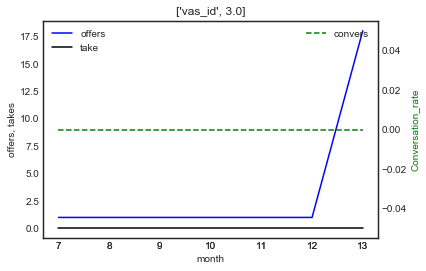

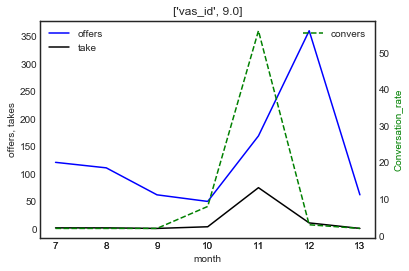

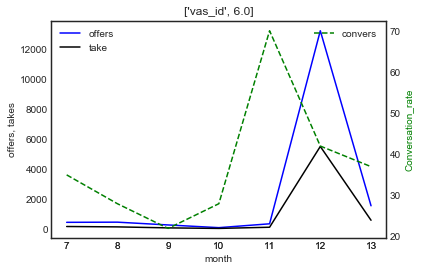

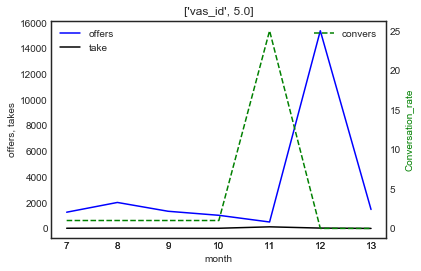

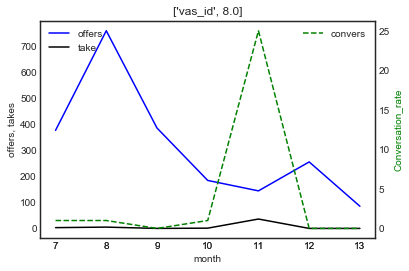

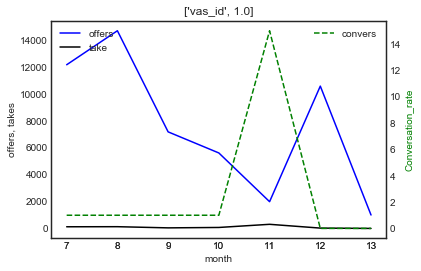

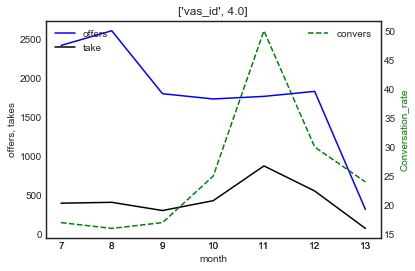

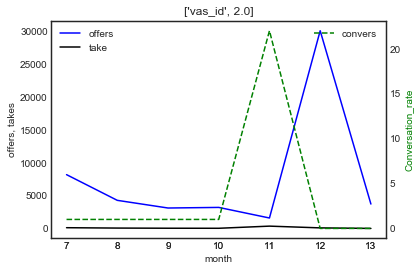

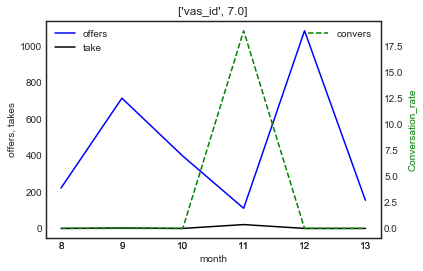

In [227]:
conversion.index = conversion.month

for i in conversion['vas_id'].unique():
    offers = conversion[conversion['vas_id'] ==i]['total_offers']
    take = conversion[conversion['vas_id'] ==i]['take']
    convers = conversion[conversion['vas_id'] ==i]['conversion, %']
    plot_dinamics(offers, take, convers, i)

In [343]:
# Найдем id, которым делали предложение более 1 раза
ids = df.groupby('id')['vas_id'].count()[df.groupby('id')['vas_id'].count() > 1].index.tolist()
df[df['id'].isin(ids)]

,id,vas_id,buy_time,target,month
142,3196972,4,2018-10-08,0,10
143,3196972,4,2018-10-08,1,10
535,540737,4,2019-01-07,0,1
536,540737,5,2019-01-07,0,1
1024,2671797,4,2018-09-17,0,9
1025,2671797,4,2018-09-17,1,9
1079,3702902,6,2018-12-10,1,12
1080,3702902,6,2018-12-10,0,12
1143,1280148,5,2018-12-31,0,12
1144,1280148,4,2018-12-24,1,12


##### Интересно, что у одной Id в один день предложения по одному и тому же vas_id есть 2 разных таргета.
Проверим одинаковые ли записи в df2 у этих  id. Если одинаковые удалим из, чтобы не зашумлять модель.

In [353]:
df21 = df2[df2['id'].isin(ids)].drop_duplicates()

In [355]:
df2[df2['id'].isin(ids)]

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
142,2119857,3196972,2018-10-08,-85,189,-77,170,-83,149,-16,...,-347,-68,-19,-38,-171,55,-1,69,-0,1
143,2119857,3196972,2018-10-08,-85,189,-77,170,-83,149,-16,...,-347,-68,-19,-38,-171,55,-1,69,-0,1
535,4118542,540737,2019-01-07,-54,-277,-68,-330,-73,-351,27,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
536,4118542,540737,2019-01-07,-54,-277,-68,-330,-73,-351,27,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
1024,2998420,2671797,2018-09-17,-59,-355,-73,-365,-78,-378,-16,...,-976,-614,-26,-38,-231,-26,-1,-12,-0,0
1025,2998420,2671797,2018-09-17,-59,-355,-73,-365,-78,-378,-16,...,-976,-614,-26,-38,-231,-26,-1,-12,-0,0
1079,2534548,3702902,2018-12-10,-97,99,-111,46,-116,29,-16,...,-673,-614,-26,-38,-266,-25,-1,-12,-0,0
1080,2534548,3702902,2018-12-10,-97,99,-111,46,-116,29,-16,...,-673,-614,-26,-38,-266,-25,-1,-12,-0,0
1143,3209567,1280148,2018-12-31,-78,-153,-92,-201,-98,-222,-16,...,-976,-613,-24,-38,-295,-25,-1,-12,-0,1
1144,953910,1280148,2018-12-24,112,38,101,-7,96,-28,-16,...,-976,-614,-24,-38,-299,-25,-1,-12,-0,1


In [354]:
df21

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
142,2119857,3196972,2018-10-08,-85,189,-77,170,-83,149,-16,...,-347,-68,-19,-38,-171,55,-1,69,-0,1
535,4118542,540737,2019-01-07,-54,-277,-68,-330,-73,-351,27,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
1024,2998420,2671797,2018-09-17,-59,-355,-73,-365,-78,-378,-16,...,-976,-614,-26,-38,-231,-26,-1,-12,-0,0
1079,2534548,3702902,2018-12-10,-97,99,-111,46,-116,29,-16,...,-673,-614,-26,-38,-266,-25,-1,-12,-0,0
1143,3209567,1280148,2018-12-31,-78,-153,-92,-201,-98,-222,-16,...,-976,-613,-24,-38,-295,-25,-1,-12,-0,1
1144,953910,1280148,2018-12-24,112,38,101,-7,96,-28,-16,...,-976,-614,-24,-38,-299,-25,-1,-12,-0,1
1171,67305,3392300,2018-11-19,-31,-305,-36,-334,-41,-356,-16,...,-977,-614,-26,-38,-307,-26,-1,-12,-0,0
1211,1348769,1634758,2018-12-17,-97,227,-111,175,-116,154,-16,...,7853,7879,-17,90,174,152,-1,-12,-0,1
1297,485008,4334890,2018-08-27,31,761,17,738,11,717,61,...,4847,4714,-21,-29,2,-19,-1,-5,-0,0
1602,3679673,1022334,2018-07-23,-97,-408,-111,-461,-116,-482,-16,...,-532,-171,-21,-33,-33,-12,6,-5,-0,1


In [346]:
df21 = df[df2['id'].isin(ids)]  .drop_duplicates()

df12 = df.drop('target',axis=1).drop_duplicates()
df2[df2['id'].isin(ids)]

In [438]:
dft = pd.read_csv('test_csv.csv', sep='\t')

In [441]:
dft['vas_id'].value_counts()

1    13421
2    13342
5     5718
6     4025
4     2996
7      678
8      564
9      223
Name: vas_id, dtype: int64

In [443]:
conversion.sort_values(by='total_offers', ascending= False)

,vas_id,total_offers,take,not_take,"conversion, %","share,%"
3,2,54217,641,53576,1,33
2,1,53171,691,52480,1,32
4,5,22986,219,22767,1,14
1,6,16322,6657,9665,41,10
0,4,12486,3078,9408,25,8
5,7,2676,23,2653,1,2
6,8,2187,45,2142,2,1
7,9,935,115,820,12,1
8,3,20,0,20,0,0


In [447]:
new = df.merge(df2, on=['id', 'buy_time'])

In [449]:
new.drop(['buy_time', 'month', 'Unnamed: 0'], axis=1, inplace=True)

In [450]:
new.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,216_0.9999166764172986,216_10.999916676417296,252_0.0,252_1.0,252_2.0,252_4.0,252_6.0,252_18.0,252_36.0,252_68.0
0,721013,4,1,-97,109,-111,87,-116,65,-16,...,0,0,0,1,0,0,0,0,0,0
1,1123097,6,1,-97,-196,-111,-249,-116,-270,-16,...,0,0,1,0,0,0,0,0,0,0
2,1123712,1,0,-88,-376,-93,-393,-99,-414,-8,...,0,0,1,0,0,0,0,0,0,0
3,132,2,0,-97,217,-111,173,-116,152,-16,...,0,0,0,1,0,0,0,0,0,0
4,1055072,5,0,-35,57,-48,97,-54,76,31,...,0,0,1,0,0,0,0,0,0,0


In [569]:
#n = new[new['vas_id'] == 6].drop(['vas_id', 'id'], axis=1).reset_index()
n = new.drop([ 'id'], axis=1).reset_index()
del n['index']
n.head()

from sklearn.preprocessing import MinMaxScaler
data = n.drop('target', axis=1)
scaler = MinMaxScaler()
nn = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
nn.head()

,vas_id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,25,26,27,28,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,...,29_4.785633684710653,30_-0.2116082160598228,30_0.7883917839401773,30_1.7883917839401773,30_2.788391783940177,30_3.788391783940177,30_4.7883917839401775,65_-0.0284538954661334,65_0.9715461045338666,65_1.9715461045338667,65_2.9715461045338665,65_3.9715461045338665,65_4.971546104533867,65_5.971546104533867,65_6.971546104533867,65_24.97154610453387,131_-3.5732830909858064,131_-2.5732830909858064,131_-1.5732830909858064,131_-0.5732830909858064,131_0.4267169090141936,131_1.4267169090141936,155_-0.00037938822761875385,155_0.9996206117723812,155_1.9996206117723807,155_2.9996206117723814,155_3.999620611772381,155_4.999620611772381,155_5.999620611772381,155_6.999620611772381,155_15.99962061177238,155_19.999620611772386,212_-0.2431363262455101,212_0.7568636737544898,212_8.616863673754489,212_9.186863673754491,212_9.926863673754491,212_148.06686367375445,212_440.4368636737545,216_-8.332358270131507e-05,216_0.9999166764172986,216_10.999916676417296,252_0.0,252_1.0,252_2.0,252_4.0,252_6.0,252_18.0,252_36.0,252_68.0
0,4.00,1.00,-96.80,109.46,-110.74,86.51,-116.16,65.41,-16.09,-65.08,-6.78,-30.01,-2.74,-4.01,-2.56,-66.19,-77.52,-0.02,-0.11,-5.42,-3.18,-13.94,-10.74,-0.09,-2.08,1,0,1.65,0,0,0,-2.66,-0.07,-0.70,-192.03,"-2,234.69","-1,115.25","-1,119.44",-89.50,-119.72,-102.00,-52.32,-49.68,-7.90,-8.00,-10.72,-28.57,-24.13,-29.09,-35.17,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,6.00,1.00,-96.80,-196.32,-110.74,-248.93,-116.16,-270.03,-16.09,-65.08,-6.78,-30.01,-2.74,-4.01,-2.56,-66.19,-77.52,-0.02,-0.11,-5.42,-3.18,-13.94,-10.74,-0.09,-2.08,1,0,-0.35,0,0,0,-2.66,-0.07,-0.70,-192.03,"-2,910.38","-1,154.71","-1,755.67",-89.50,-119.72,-105.81,-47.25,-58.56,-7.90,-8.00,-10.72,-28.57,-4.13,-9.09,-35.17,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,1.00,0.00,-88.41,-375.80,-93.46,-392.85,-98.88,-413.95,-7.70,-56.69,-6.78,-30.01,5.65,-4.01,-2.56,-66.19,-77.52,-0.02,-0.11,-5.42,-3.18,-5.05,-10.74,-0.09,-2.08,0,0,-0.35,0,0,0,-2.66,-0.07,-0.70,-192.03,"-2,942.44","-1,186.76","-1,755.67",-89.50,-119.72,-119.66,-54.60,-65.06,-7.90,-8.00,"8,576.80","8,558.94",-17.13,-22.09,23.83,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,2.00,0.00,-96.80,216.78,-110.74,172.65,-116.16,151.55,-16.09,290.81,-6.78,-30.01,-2.74,-4.01,-2.56,-66.19,-77.52,-0.02,-0.11,-5.42,-3.18,-13.94,-10.74,-0.09,-2.08,1,0,-0.35,0,0,0,-2.66,-0.07,-0.70,-122.03,-237.21,"-1,097.74",860.53,-89.50,-119.72,-73.88,-39.97,-33.91,-7.90,-8.00,-10.72,-28.53,14.87,9.91,11.83,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,5.00,0.00,-34.51,56.66,-48.45,97.27,-53.87,76.17,31.37,117.98,40.68,153.05,-2.74,-4.01,-2.56,-66.19,-66.93,-0.02,-0.11,-5.42,1.06,-13.94,36.72,-0.09,-2.08,1,0,1.65,0,0,0,38.02,-0.07,-0.70,57.97,"28,834.30","30,589.97","-1,755.67",-89.50,-119.72,22.10,-17.20,39.31,-7.90,-7.92,-10.72,-28.57,5.87,17.91,6.83,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [596]:
nn.drop(aaa, axis=1, inplace=True)

In [597]:
train, test, y_train, y_test = train_test_split(nn, n['target'], test_size=0.33, random_state=42)

#rfc = RandomForestClassifier(n_jobs=-1, random_state=72, max_depth=3)
rfc = XGBClassifier()
#rfc = CatBoostClassifier()
#rfc = LogisticRegression()

rfc.fit(train, y_train)

y_pred_train = rfc.predict_proba(train)
y_pred_test = rfc.predict_proba(test)

y_pred_train_bin = rfc.predict(train)
y_pred_test_bin = rfc.predict(test)

importances_rfc = pd.DataFrame(abs(rfc.feature_importances_.T), train.columns).reset_index()
importances_rfc.columns='feature', 'score'
importances_rfc = importances_rfc.sort_values(by='score', ascending =False)
    
metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
metrics
importances_rfc

,feature,score
0,vas_id,0.33
80,222,0.20
72,191,0.02
98,250,0.02
3,3,0.02
74,201,0.02
30,59,0.02
57,144,0.02
73,193,0.01
48,126,0.01


In [599]:
aaa = importances_rfc[importances_rfc['score']==0]['feature'].tolist()

In [600]:
aaa

[]

In [ ]:
y_pred_train 
y_pred_test = rfc.predict_proba(test)

In [ ]:
y_pred_train 
y_pred_test = rfc.predict_proba(test)

In [590]:
new[['191', '222', 'target']].corr()

,191,222,target
191,1.00,-0.04,-0.04
222,-0.04,1.00,0.00
target,-0.04,0.00,1.00


In [591]:
new.corr().to_csv('co.csv')

In [598]:
for i in [0.1,0.2,0.3,0.4,]:
    y_pred_train_bin = np.where(y_pred_train[:,1]>i,1,0)
    y_pred_test_bin = np.where(y_pred_test[:,1]>i,1,0)

    metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
    print(metrics)
    print(i)

{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.35, 'Precision_train': 0.34, 'Recall_test': 0.89, 'Recall_train': 0.88, 'Accuracy_test': 0.87, 'Accuracy_train': 0.87, 'F1_score_test': 0.71, 'F1_score_train': 0.71}
0.1
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.37, 'Precision_train': 0.37, 'Recall_test': 0.84, 'Recall_train': 0.84, 'Accuracy_test': 0.88, 'Accuracy_train': 0.89, 'F1_score_test': 0.72, 'F1_score_train': 0.72}
0.2
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.42, 'Precision_train': 0.43, 'Recall_test': 0.63, 'Recall_train': 0.63, 'Accuracy_test': 0.91, 'Accuracy_train': 0.91, 'F1_score_test': 0.73, 'F1_score_train': 0.73}
0.3
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.44, 'Precision_train': 0.47, 'Recall_test': 0.42, 'Recall_train': 0.44, 'Accuracy_test': 0.92, 'Accuracy_train': 0.92, 'F1_score_test': 0.7, 'F1_score_train': 0.71}
0.4


In [583]:
for i in [0.1,0.2,0.3,0.4, 0.5]:
    y_pred_train_bin = np.where(y_pred_train[:,1]>i,1,0)
    y_pred_test_bin = np.where(y_pred_test[:,1]>i,1,0)

    metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
    print(metrics)
    print(i)

{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.35, 'Precision_train': 0.34, 'Recall_test': 0.89, 'Recall_train': 0.88, 'Accuracy_test': 0.87, 'Accuracy_train': 0.87, 'F1_score_test': 0.71, 'F1_score_train': 0.71}
0.1
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.37, 'Precision_train': 0.37, 'Recall_test': 0.84, 'Recall_train': 0.84, 'Accuracy_test': 0.88, 'Accuracy_train': 0.89, 'F1_score_test': 0.72, 'F1_score_train': 0.72}
0.2
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.42, 'Precision_train': 0.43, 'Recall_test': 0.63, 'Recall_train': 0.63, 'Accuracy_test': 0.91, 'Accuracy_train': 0.91, 'F1_score_test': 0.73, 'F1_score_train': 0.73}
0.3
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.44, 'Precision_train': 0.47, 'Recall_test': 0.42, 'Recall_train': 0.44, 'Accuracy_test': 0.92, 'Accuracy_train': 0.92, 'F1_score_test': 0.7, 'F1_score_train': 0.71}
0.4
{'Gini_test': 0.81, 'Gini_train': 0.82, 'Precision_test': 0.75, 'Precision_train'

In [584]:
y_pred_train_bin = np.where(y_pred_train[:,1]>0.4,1,0)
y_pred_test_bin = np.where(y_pred_test[:,1]>0.4,1,0)

In [585]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test_bin))

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96     50813
        1.0       0.44      0.42      0.43      3951

avg / total       0.92      0.92      0.92     54764



In [586]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train_bin))

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96    103220
        1.0       0.47      0.44      0.46      7966

avg / total       0.92      0.92      0.92    111186



In [514]:
!pip install signature
#import signature

ERROR: Could not find a version that satisfies the requirement signature (from versions: none)
ERROR: No matching distribution found for signature


In [517]:
from sklearn.metrics import average_precision_score

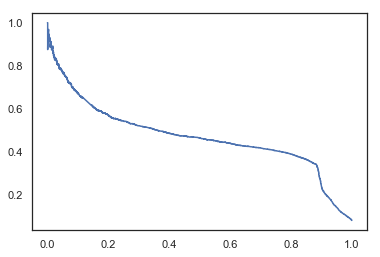

In [520]:
plt.plot(recall, precision)

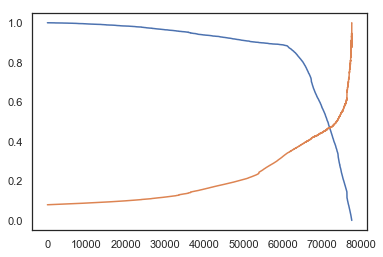

In [524]:
plt.plot(recall)
plt.plot(precision)

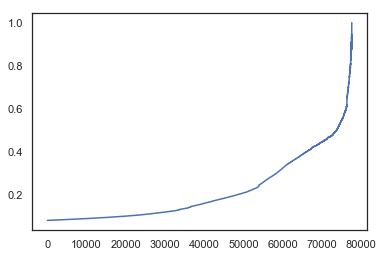

Text(0.5,1,'2-class Precision-Recall curve: AP=0.47')

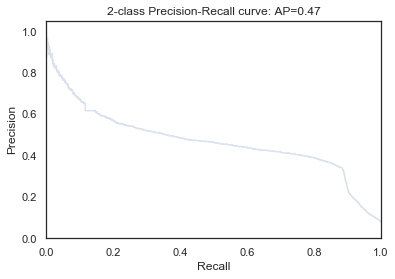

In [519]:
precision, recall, _ = precision_recall_curve(y_train, y_pred_train[:,1])
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(y_train, y_pred_train[:,1])))

In [493]:
metrics

{'Accuracy_test': 0.93,
 'Accuracy_train': 0.93,
 'F1_score_test': 0.07,
 'F1_score_train': 0.07,
 'Gini_test': 0.81,
 'Gini_train': 0.82,
 'Precision_test': 0.75,
 'Precision_train': 0.81,
 'Recall_test': 0.04,
 'Recall_train': 0.03}

In [562]:
def metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin):
    metrics = {
        'Gini_test'      : round (2 * roc_auc_score(y_test, y_pred_test[:,1])   - 1, 2),
        'Gini_train'     : round (2 * roc_auc_score(y_train, y_pred_train[:,1]) - 1, 2),
        'Precision_test' : round (precision_score  (y_test, y_pred_test_bin )      , 2),
        'Precision_train': round (precision_score  (y_train, y_pred_train_bin )    , 2),
        'Recall_test'    : round (recall_score     (y_test, y_pred_test_bin)       , 2),
        'Recall_train'   : round (recall_score     (y_train, y_pred_train_bin)     , 2),
        'Accuracy_test'  : round (accuracy_score   (y_test, y_pred_test_bin)       , 2),
        'Accuracy_train' : round (accuracy_score   (y_train, y_pred_train_bin)     , 2),
        'F1_score_test'  : round (f1_score(y_test, y_pred_test_bin, average='macro')                , 2),
        'F1_score_train' : round (f1_score(y_train, y_pred_train_bin,average='macro')              , 2) 
                }
    return metrics

In [481]:
metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
metrics

{'Accuracy_test': 0.99,
 'Accuracy_train': 0.99,
 'F1_score_test': 0.11,
 'F1_score_train': 0.18,
 'Gini_test': 0.43,
 'Gini_train': 0.76,
 'Precision_test': 0.72,
 'Precision_train': 0.86,
 'Recall_test': 0.06,
 'Recall_train': 0.1}

In [601]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [ ]:
NN = nn.drop(feature_df[feature_df['rank']==1]['features'].tolist(), axis=1)
train, test, y_train, y_test = train_test_split(NN, n['target'], test_size=0.33, random_state=42)

#rfc = RandomForestClassifier(n_jobs=-1, random_state=72, max_depth=3)
rfc = XGBClassifier()
#rfc = CatBoostClassifier()
#rfc = LogisticRegression()

rfc.fit(train, y_train)

y_pred_train = rfc.predict_proba(train)
y_pred_test = rfc.predict_proba(test)

y_pred_train_bin = rfc.predict(train)
y_pred_test_bin = rfc.predict(test)

importances_rfc = pd.DataFrame(abs(rfc.feature_importances_.T), train.columns).reset_index()
importances_rfc.columns='feature', 'score'
importances_rfc = importances_rfc.sort_values(by='score', ascending =False)
    
metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
metrics
importances_rfc

In [604]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight='balanced', max_depth=6)
rfc.fit(train, y_train)
y_pred_train = rfc.predict_proba(train)
y_pred_test = rfc.predict_proba(test)
Gini_train = 2 * roc_auc_score(y_train, y_pred_train[:,1]) - 1
Gini_test = 2 * roc_auc_score(y_test, y_pred_test[:,1]) - 1
print(Gini_train, Gini_test)

0.8202272720970734 0.8064271901673026


In [607]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [609]:
from __future__ import print_function


In [611]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight='balanced', max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(train.values, y_train.values)

feature_df = pd.DataFrame(train.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df[feature_df['rank']==1]['features'].tolist()
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	24
Rejected: 	63
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	24
Rejected: 	63
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	24
Rejected: 	63
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	24
Rejected: 	63
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	17
Rejected: 	68
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	17
Rejected: 	68
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	17
Rejected: 	68
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	17
Rejected: 	68
Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	

BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=105, n_jobs=4, oob_score=False,
            random_state=<mtrand.RandomState object at 0x10da62828>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x10da62828>,
     two_step=True, verbose=2)

In [612]:
print (boruta_selector.n_features_)

16


In [623]:
boruta_selector.ranking_

array([ 1,  2,  1,  1,  1,  1, 18, 75, 63,  1, 49, 11, 55, 69, 64, 71, 53,
       15,  4,  6, 76, 27, 29, 79, 10,  1, 13, 40, 59, 11, 38, 51, 45, 25,
       54, 48, 16, 45, 67, 74, 60, 64, 45, 58, 16, 56, 34, 14, 33, 36, 50,
       35, 67,  6, 60, 82, 29,  3, 45, 80, 42, 81, 62, 78,  1, 29, 72, 66,
       40, 19,  8, 82,  1, 23,  1,  1, 52, 36, 84, 77,  1,  1,  4, 25, 70,
       32, 24, 40, 42,  9, 20, 31, 20, 22, 57,  1,  1, 73,  1])

In [621]:
boruta_selector.support_

array([ True, False,  True,  True,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False,  True,  True, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True])

In [629]:
features_important = feature_df[feature_df['rank']==1]['features'].tolist()

NN = nn[features_important]
train, test, y_train, y_test = train_test_split(NN, n['target'], test_size=0.33, random_state=42)

#rfc = RandomForestClassifier(n_jobs=-1, random_state=72, max_depth=3)
rfc = XGBClassifier()
#rfc = CatBoostClassifier()
#rfc = LogisticRegression()

rfc.fit(train, y_train)

y_pred_train = rfc.predict_proba(train)
y_pred_test = rfc.predict_proba(test)

y_pred_train_bin = rfc.predict(train)
y_pred_test_bin = rfc.predict(test)

importances_rfc = pd.DataFrame(abs(rfc.feature_importances_.T), train.columns).reset_index()
importances_rfc.columns='feature', 'score'
importances_rfc = importances_rfc.sort_values(by='score', ascending =False)
    
metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
metrics
importances_rfc

,feature,score
0,vas_id,0.38
4,222,0.25
5,207,0.04
7,191,0.04
13,3,0.04
2,247,0.04
10,250,0.04
14,5,0.03
1,248,0.03
11,2,0.03


In [630]:
metrics

{'Accuracy_test': 0.93,
 'Accuracy_train': 0.93,
 'F1_score_test': 0.52,
 'F1_score_train': 0.52,
 'Gini_test': 0.81,
 'Gini_train': 0.81,
 'Precision_test': 0.71,
 'Precision_train': 0.71,
 'Recall_test': 0.05,
 'Recall_train': 0.04}

In [631]:
for i in [0.1,0.2,0.3,0.4, 0.5]:
    y_pred_train_bin = np.where(y_pred_train[:,1]>i,1,0)
    y_pred_test_bin = np.where(y_pred_test[:,1]>i,1,0)

    metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
    print(metrics)
    print(i)

{'Gini_test': 0.81, 'Gini_train': 0.81, 'Precision_test': 0.35, 'Precision_train': 0.34, 'Recall_test': 0.89, 'Recall_train': 0.88, 'Accuracy_test': 0.87, 'Accuracy_train': 0.87, 'F1_score_test': 0.71, 'F1_score_train': 0.71}
0.1
{'Gini_test': 0.81, 'Gini_train': 0.81, 'Precision_test': 0.37, 'Precision_train': 0.37, 'Recall_test': 0.84, 'Recall_train': 0.84, 'Accuracy_test': 0.88, 'Accuracy_train': 0.88, 'F1_score_test': 0.72, 'F1_score_train': 0.72}
0.2
{'Gini_test': 0.81, 'Gini_train': 0.81, 'Precision_test': 0.42, 'Precision_train': 0.43, 'Recall_test': 0.63, 'Recall_train': 0.63, 'Accuracy_test': 0.91, 'Accuracy_train': 0.91, 'F1_score_test': 0.73, 'F1_score_train': 0.73}
0.3
{'Gini_test': 0.81, 'Gini_train': 0.81, 'Precision_test': 0.44, 'Precision_train': 0.46, 'Recall_test': 0.45, 'Recall_train': 0.46, 'Accuracy_test': 0.92, 'Accuracy_train': 0.92, 'F1_score_test': 0.7, 'F1_score_train': 0.71}
0.4
{'Gini_test': 0.81, 'Gini_train': 0.81, 'Precision_test': 0.71, 'Precision_train'

In [633]:
#n = new[new['vas_id'] == 6].drop(['vas_id', 'id'], axis=1).reset_index()
n = new.drop(['vas_id', 'id'], axis=1).reset_index()
del n['index']
n.head()

from sklearn.preprocessing import MinMaxScaler
data = n.drop('target', axis=1)
scaler = MinMaxScaler()
nn = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
nn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,25,26,27,28,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,...,29_4.785633684710653,30_-0.2116082160598228,30_0.7883917839401773,30_1.7883917839401773,30_2.788391783940177,30_3.788391783940177,30_4.7883917839401775,65_-0.0284538954661334,65_0.9715461045338666,65_1.9715461045338667,65_2.9715461045338665,65_3.9715461045338665,65_4.971546104533867,65_5.971546104533867,65_6.971546104533867,65_24.97154610453387,131_-3.5732830909858064,131_-2.5732830909858064,131_-1.5732830909858064,131_-0.5732830909858064,131_0.4267169090141936,131_1.4267169090141936,155_-0.00037938822761875385,155_0.9996206117723812,155_1.9996206117723807,155_2.9996206117723814,155_3.999620611772381,155_4.999620611772381,155_5.999620611772381,155_6.999620611772381,155_15.99962061177238,155_19.999620611772386,212_-0.2431363262455101,212_0.7568636737544898,212_8.616863673754489,212_9.186863673754491,212_9.926863673754491,212_148.06686367375445,212_440.4368636737545,216_-8.332358270131507e-05,216_0.9999166764172986,216_10.999916676417296,252_0.0,252_1.0,252_2.0,252_4.0,252_6.0,252_18.0,252_36.0,252_68.0
0,0.12,0.04,0.04,0.02,0.04,0.02,0.01,0.01,0.02,0.00,0.00,0.01,0.00,0.25,0.24,0.00,0.00,0.02,0.01,0.01,0.02,0.00,0.01,1.00,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.12,0.03,0.04,0.01,0.04,0.01,0.01,0.01,0.02,0.00,0.00,0.01,0.00,0.25,0.24,0.00,0.00,0.02,0.01,0.01,0.02,0.00,0.01,1.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.12,0.03,0.04,0.01,0.04,0.01,0.01,0.01,0.02,0.00,0.00,0.01,0.00,0.25,0.24,0.00,0.00,0.02,0.01,0.01,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.14,0.05,0.00,0.00,0.01,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.12,0.05,0.04,0.02,0.04,0.02,0.01,0.02,0.02,0.00,0.00,0.01,0.00,0.25,0.24,0.00,0.00,0.02,0.01,0.01,0.02,0.00,0.01,1.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.03,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.12,0.04,0.05,0.02,0.05,0.02,0.02,0.01,0.03,0.01,0.00,0.01,0.00,0.25,0.25,0.00,0.00,0.02,0.01,0.01,0.03,0.00,0.01,1.00,0.00,0.13,0.00,0.00,0.00,0.07,0.00,0.03,0.00,0.08,0.08,0.00,0.00,0.00,0.04,0.02,0.04,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.01,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [634]:
train, test, y_train, y_test = train_test_split(nn, n['target'], test_size=0.33, random_state=42)

rfc = RandomForestClassifier(n_estimators=200, n_jobs=4, class_weight='balanced', max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(train.values, y_train.values)

feature_df = pd.DataFrame(train.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

feature_df[feature_df['rank']==1]['features'].tolist()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	41
Rejected: 	259
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	31
Rejected: 	259
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	31
Rejected: 	259
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	31
Rejected: 	259
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	26
Rejected: 	263
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	26
Rejected: 	263
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	26
Rejected: 	263
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	26
Rejected: 	263
Iteration: 	16 / 100
Confirmed: 	1

In [636]:
aaaaa = feature_df[feature_df['rank']==1]['features'].tolist()
aaaaa

['0',
 '52',
 '158',
 '250',
 '248',
 '247',
 '102',
 '201',
 '207',
 '222',
 '223',
 '191',
 '4',
 '5',
 '3',
 '2']

In [637]:
NN = nn[aaaaa]
train, test, y_train, y_test = train_test_split(NN, n['target'], test_size=0.33, random_state=42)

#rfc = RandomForestClassifier(n_jobs=-1, random_state=72, max_depth=3)
rfc = XGBClassifier()
#rfc = CatBoostClassifier()
#rfc = LogisticRegression()

rfc.fit(train, y_train)

y_pred_train = rfc.predict_proba(train)
y_pred_test = rfc.predict_proba(test)

y_pred_train_bin = rfc.predict(train)
y_pred_test_bin = rfc.predict(test)

importances_rfc = pd.DataFrame(abs(rfc.feature_importances_.T), train.columns).reset_index()
importances_rfc.columns='feature', 'score'
importances_rfc = importances_rfc.sort_values(by='score', ascending =False)
    
metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
metrics
importances_rfc

,feature,score
9,222,0.19
3,250,0.11
8,207,0.08
4,248,0.08
5,247,0.07
11,191,0.07
10,223,0.06
1,52,0.05
7,201,0.05
13,5,0.05


In [638]:
metrics

{'Accuracy_test': 0.93,
 'Accuracy_train': 0.93,
 'F1_score_test': 0.53,
 'F1_score_train': 0.52,
 'Gini_test': 0.29,
 'Gini_train': 0.31,
 'Precision_test': 0.75,
 'Precision_train': 0.66,
 'Recall_test': 0.05,
 'Recall_train': 0.04}

In [639]:
for i in [0.1,0.2,0.3,0.4, 0.5]:
    y_pred_train_bin = np.where(y_pred_train[:,1]>i,1,0)
    y_pred_test_bin = np.where(y_pred_test[:,1]>i,1,0)

    metrics = metrics_calc(y_train, y_test, y_pred_test, y_pred_train, y_pred_test_bin, y_pred_train_bin)
    print(metrics)
    print(i)

{'Gini_test': 0.29, 'Gini_train': 0.31, 'Precision_test': 0.18, 'Precision_train': 0.18, 'Recall_test': 0.17, 'Recall_train': 0.17, 'Accuracy_test': 0.88, 'Accuracy_train': 0.88, 'F1_score_test': 0.56, 'F1_score_train': 0.56}
0.1
{'Gini_test': 0.29, 'Gini_train': 0.31, 'Precision_test': 0.68, 'Precision_train': 0.61, 'Recall_test': 0.06, 'Recall_train': 0.06, 'Accuracy_test': 0.93, 'Accuracy_train': 0.93, 'F1_score_test': 0.54, 'F1_score_train': 0.53}
0.2
{'Gini_test': 0.29, 'Gini_train': 0.31, 'Precision_test': 0.73, 'Precision_train': 0.64, 'Recall_test': 0.06, 'Recall_train': 0.05, 'Accuracy_test': 0.93, 'Accuracy_train': 0.93, 'F1_score_test': 0.54, 'F1_score_train': 0.53}
0.3
{'Gini_test': 0.29, 'Gini_train': 0.31, 'Precision_test': 0.75, 'Precision_train': 0.65, 'Recall_test': 0.06, 'Recall_train': 0.05, 'Accuracy_test': 0.93, 'Accuracy_train': 0.93, 'F1_score_test': 0.54, 'F1_score_train': 0.53}
0.4
{'Gini_test': 0.29, 'Gini_train': 0.31, 'Precision_test': 0.75, 'Precision_train